In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install diffusers transformers accelerate datasets
!pip install safetensors
!pip install diffusers transformers datasets torch torchvision pillow accelerate
!pip install controlnet_aux
!pip install --upgrade huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import torch
from diffusers import StableDiffusionPipeline, UNet2DConditionModel, DDPMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import json
import torch
from diffusers import StableDiffusionPipeline, UNet2DConditionModel, AutoencoderKL, ControlNetModel, UniPCMultistepScheduler, StableDiffusionControlNetPipeline, DPMSolverMultistepScheduler, AutoPipelineForText2Image
import torch.nn as nn
from controlnet_aux import OpenposeDetector
from diffusers.models.attention_processor import LoRAAttnProcessor

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


In [5]:
from huggingface_hub import login

with open('/content/drive/MyDrive/BigProject/token.txt', 'r') as f:
    hf_token = f.read().strip()

login(token=hf_token)

In [6]:
from huggingface_hub import hf_hub_download

device = "cuda" if torch.cuda.is_available() else "cpu"

# 모델 ID 및 장치 설정
model_id = "stable-diffusion-v1-5/stable-diffusion-v1-5"
# unet_weights_path = '/content/drive/MyDrive/model_checkpoints/best_model.pth'
unet_weights_path = hf_hub_download(
    repo_id="lee124/sd1.5_fine_tuned",
    filename="best_model.pth"
)

# Stable Diffusion 파이프라인 로드
pipeline = AutoPipelineForText2Image.from_pretrained(
    model_id
)

pipeline.scheduler = UniPCMultistepScheduler.from_config(pipeline.scheduler.config)
pipeline.safety_checker = None  # NSFW 감지 비활성화

#가중치 로드
state_dict = torch.load(unet_weights_path)
pipeline.unet.load_state_dict(state_dict)

pipeline.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


best_model.pth:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

<ipython-input-6-668be6139dc9>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(unet_weights_path)


StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.32.2",
  "_name_or_path": "stable-diffusion-v1-5/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "UniPCMultistepScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [ ]:
# 캐릭터 생성 함수
import os
from PIL import Image
import matplotlib.pyplot as plt
import torch

def generate_character_images_fixed(prompt, output_dir="generated_characters"):
    # 고정된 설정값
  negative_prompt = '''FastNegativeV2,(bad-artist:1.0),
(worst quality, low quality:1.4), (bad_prompt_version2:0.8),
bad-hands-5,lowres, bad anatomy, bad hands, ((text)), (watermark),
error, missing fingers, extra digit, fewer digits, cropped,
worst quality, low quality, normal quality, ((username)), blurry,
(extra limbs), bad-artist-anime, badhandv4, EasyNegative,
ng_deepnegative_v1_75t, verybadimagenegative_v1.3, BadDream,
(three hands:1.1),(three legs:1.1),(more than two hands:1.4),
(more than two legs,:1.2),badhandv4,EasyNegative,ng_deepnegative_v1_75t,verybadimagenegative_v1.3,(worst quality, low quality:1.4),text,words,logo,watermark, overposed
'''
  guidance_scale = 7.5
  num_inference_steps = 100
  height = 512
  width = 512
  os.makedirs(output_dir, exist_ok=True)  # 결과 저장 디렉토리 생성
  # 이미지 생성
  with torch.no_grad():
      generated_images = pipeline(
          prompt=[prompt] * 4,  # 동일한 프롬프트로 4개의 이미지 생성
          negative_prompt=[negative_prompt] * 4,  # 부정 프롬프트 추가
          num_inference_steps=num_inference_steps,  # 단계 수
          guidance_scale=guidance_scale,  # 텍스트 조건의 강도
          height=height,  # 이미지 높이
          width=width  # 이미지 너비
      ).images

  # 생성된 이미지 출력
  fig, axes = plt.subplots(1, 4, figsize=(16, 4))
  for i, img in enumerate(generated_images):
      axes[i].imshow(img)
      axes[i].axis("off")
  plt.tight_layout()
  plt.show()

  # 사용자로부터 선택 받기
  selected_index = int(input("마음에 드는 이미지를 선택하세요 (0-3): "))
  assert 0 <= selected_index < 4, "0에서 3 사이의 숫자를 입력해주세요."

  # 선택된 이미지 저장
  selected_image = generated_images[selected_index]
  character_name = input("저장할 캐릭터 이름을 입력하세요: ")
  save_path = os.path.join(output_dir, f"{character_name}.png")
  selected_image.save(save_path)

  print(f"선택된 이미지가 {save_path}에 저장되었습니다.")

  return selected_image, character_name

  0%|          | 0/100 [00:00<?, ?it/s]

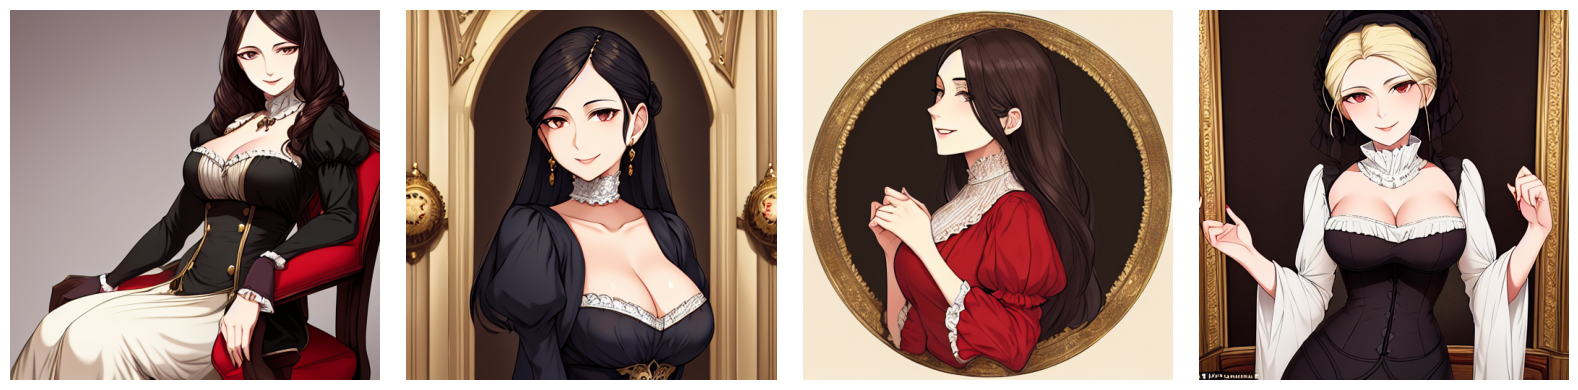

마음에 드는 이미지를 선택하세요 (0-3): 1
저장할 캐릭터 이름을 입력하세요: Jane
선택된 이미지가 generated_characters/Jane.png에 저장되었습니다.


(<PIL.Image.Image image mode=RGB size=512x512>, 'Jane')

In [ ]:
generate_character_images_fixed(""" Historical setting: England, early 19th century, overall appearance, woman, Dark eyes, lively expression, and captivating smile, Medium height and slim body type. """)

In [ ]:
#컨트롤넷모델 불러오기
controlnet_lineart = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15s2_lineart_anime")
controlnet_openpose = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_openpose")
# controlnet_face_landmark = ControlNetModel.from_pretrained("georgefen/Face-Landmark-ControlNet", subfolder='models_for_diffusers')
# controlnet_canny = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny")

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/999 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

In [ ]:
#컨트롤넷적용해서 파이프라인 재정의
from controlnet_aux import LineartAnimeDetector

# 모델 ID 및 장치 설정
model_id = "stable-diffusion-v1-5/stable-diffusion-v1-5"
# unet_weights_path = '/content/drive/MyDrive/model_checkpoints/best_model.pth'
unet_weights_path = hf_hub_download(
    repo_id="lee124/sd1.5_fine_tuned",
    filename="best_model.pth"
)

pipeline = StableDiffusionControlNetPipeline.from_pretrained(
    model_id,
    controlnet=[controlnet_lineart, controlnet_openpose]
)

openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")
lineart = LineartAnimeDetector.from_pretrained("lllyasviel/Annotators")
# # 페이스 랜드마크 검출기 초기화
# face_detector = face_alignment.FaceAlignment(face_alignment.LandmarksType.TWO_D, flip_input=False)

pipeline.scheduler = UniPCMultistepScheduler.from_config(pipeline.scheduler.config)

#가중치 로드
state_dict = torch.load(unet_weights_path)
pipeline.unet.load_state_dict(state_dict)

pipeline.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

body_pose_model.pth:   0%|          | 0.00/209M [00:00<?, ?B/s]

hand_pose_model.pth:   0%|          | 0.00/147M [00:00<?, ?B/s]

facenet.pth:   0%|          | 0.00/154M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/controlnet_aux/open_pose/body.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = util.transfer(self.model, torch.load(

netG.pth:   0%|          | 0.00/218M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/controlnet_aux/lineart_anime/__init__.py:131: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(model_path)
<ipython-in

StableDiffusionControlNetPipeline {
  "_class_name": "StableDiffusionControlNetPipeline",
  "_diffusers_version": "0.32.2",
  "_name_or_path": "stable-diffusion-v1-5/stable-diffusion-v1-5",
  "controlnet": [
    "diffusers",
    "MultiControlNetModel"
  ],
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "UniPCMultistepScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [ ]:
#생성한 이미지 유지 확인용
import os
from PIL import Image
import matplotlib.pyplot as plt
import torch
import random
import numpy as np
from torchvision import transforms
import torch
from diffusers.utils import load_image

# 특정 상황 이미지 생성 함수
def generate_situation_image_with_character_fixed(character_name, situation_prompt, output_dir="situation_images"):
  # 고정된 설정값
  negative_prompt = '''FastNegativeV2,(bad-artist:1.0),
(worst quality, low quality:1.4), (bad_prompt_version2:0.8),
bad-hands-5,lowres, bad anatomy, bad hands, ((text)), (watermark),
error, missing fingers, extra digit, fewer digits, cropped,
worst quality, low quality, normal quality, ((username)), blurry,
(extra limbs), bad-artist-anime, badhandv4, EasyNegative,
ng_deepnegative_v1_75t, verybadimagenegative_v1.3, BadDream,
(three hands:1.1),(three legs:1.1),(more than two hands:1.4),
(more than two legs,:1.2),badhandv4,EasyNegative,ng_deepnegative_v1_75t,verybadimagenegative_v1.3,(worst quality, low quality:1.4),
text,words,logo,watermark,
different appearance, different outfit, different clothing color, different hair color,
changed appearance, changed outfit, changed clothing color, changed hair color,
inconsistent appearance, inconsistent outfit, inconsistent clothing color, inconsistent hair color
'''
  guidance_scale = 7.5
  num_inference_steps = 150
  height = 512
  width = 512

  os.makedirs(output_dir, exist_ok=True)  # 결과 저장 디렉토리 생성

  # 캐릭터 이미지 경로 생성
  character_image_path = os.path.join("/content/generated_characters", f"{character_name}.png")
  if not os.path.exists(character_image_path):
      raise FileNotFoundError(f"캐릭터 이미지 {character_image_path}가 존재하지 않습니다.")

  # 캐릭터 이미지를 로드
  character_image = load_image(character_image_path)

   # Openpose를 사용하여 포즈 추출
  pose_image = openpose(character_image)
  #canny_image = get_canny_image(character_image)
  lineart_image = lineart(character_image)

  # 상황에 맞는 이미지 생성 (Image-to-Image)
  with torch.no_grad():
      situation_image = pipeline(
          prompt=[situation_prompt],  # 상황 프롬프트
          negative_prompt=[negative_prompt],  # 부정 프롬프트
          num_inference_steps=num_inference_steps,  # 단계 수
          guidance_scale=guidance_scale,  # 텍스트 조건의 강도
          height=height,  # 이미지 높이
          width=width,  # 이미지 너비
          controlnet_conditioning_scale=[0.4, 0.6], #0.7,0.2(최고로 잘나옴)
          control_guidance_start=[0.0, 0.0],
          control_guidance_end=[0.5, 1.0],
          image=[lineart_image, pose_image],  # 포즈 이미지
          guess_mode=True,
          strength=0.1
      ).images[0]

  return situation_image

  0%|          | 0/150 [00:00<?, ?it/s]

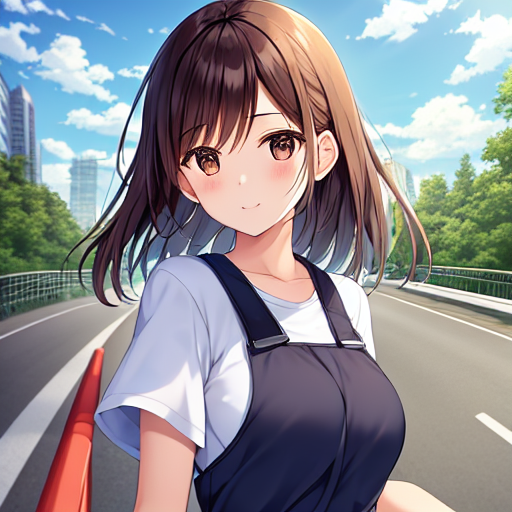

In [ ]:
generate_situation_image_with_character_fixed("Jane", "running on the road, overall appearance")

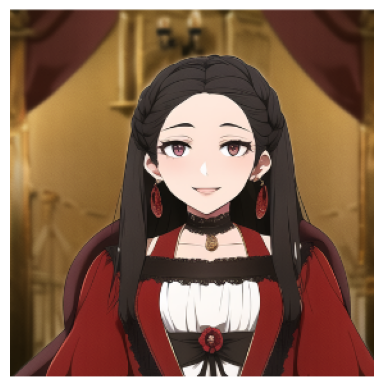

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지 불러오기
image = Image.open("/content/drive/MyDrive/BigProject/img_exam/test3.png")
image.show()

plt.imshow(np.array(image))
plt.axis('off')
plt.show()

  0%|          | 0/150 [00:00<?, ?it/s]

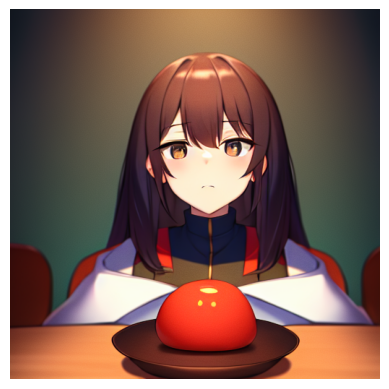

In [ ]:
#다운받은 이미지 유지 확인용

# Openpose를 사용하여 포즈 추출
pose_image = openpose(image)
#canny_image = get_canny_image(character_image)
lineart_image = lineart(image)

output = pipeline(
    prompt='''best quality, high quality, 1person, sitting at the table, There is food on it, Expressionless''',
    negative_prompt = '''
(worst quality, low quality:1.4),
(bad-artist:1.0),
bad-hands-5,
lowres,
bad anatomy,
((text)),
(watermark),
error,
missing fingers,
extra digit,
fewer digits,
cropped,
blurry,
(extra limbs),
badhandv4,
EasyNegative,
ng_deepnegative_v1_75t,
verybadimagenegative_v1.3,
BadDream,
(three hands:1.1),
(three legs:1.1),
(more than two hands:1.4),
(more than two legs:1.2),
text,
words,
logo,
overexposed
''',
    num_inference_steps=150,
    height=512,
    width=512,
    guidance_scale=9.5,
    controlnet_conditioning_scale=[0.3, 0.7], #0.7,0.2(최고로 잘나옴)
    control_guidance_start=[0.0, 0.0],
    control_guidance_end=[0.5, 1.0],
    image=[lineart_image, pose_image],  # 포즈 이미지
    guess_mode=True,
    strength=0.1
)
plt.imshow(np.array(output.images[0]))
plt.axis('off')
plt.show()